In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from tqdm import tqdm
import argparse
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import random # for random choice of nodes

In [ ]:
################################ Data loading- features-test #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn')
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

#############################  preprocessing ############################
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

# print ("adj shape: ", adj.shape)
print ("features shape: ", features.shape)
# print ("labels shape: ", labels.shape)  
print (features)



In [5]:
################################# V0: adding edges - Attack repeatedly - consider crypto'Graph ###############################
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset , setting='gcn', seed=15)   
# setting='gcn' is for the GCN model, in latest experiments befor 2024-06-11 used default which is nettack
# seed=15 is for the GCN model, in latest experiments befor 2024-06-11 no seeds were used. seed is used to make the results reproducible
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems


for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ##split idx_test into two parts randomly
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])

    # Split graph into two subgraphs for Crypto'Graph: by randomly removing some edges.but the nodes are the same
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 
    
    print ("adj1 shape: ", adj1.shape)
    print ("adj2 shape: ", adj2.shape)
    gr1 = nx.from_scipy_sparse_array(adj1)
    gr2 = nx.from_scipy_sparse_array(adj2)
    print(f"adj1 is ",gr1)
    print(f"adj2 is ",gr2)


    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print (f"idx_test_attack",idx_test_attack)
    # print (f"idx_test_clean",idx_test_clean)
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print (idx_train)
    # print ("val",len (idx_val))

    print ("adj shape: ", adj.shape)
    print ("features shape: ", features.shape)
    print ("labels shape: ", labels.shape)
    # print (f"adj", adj)
    # print (f"adj1",adj1)
    # print (f"adj2",adj2)

    # graph = nx.from_scipy_sparse_array(adj1)
    # print(f"graph edges : {graph.number_of_edges()}")
    # print(f"graph nodes : {graph.number_of_nodes()}")
    

    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)
    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)

    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)
        
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total inserted edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # diff_adj_attack = modified_adj1 - adj1
    # print("Differences in adj1 after attack (non-zero entries indicate changes):")
    # print(diff_adj_attack)


    # Function to compare two graphs and find differences
    def compare_graphs(graph1, graph2):
        edges1 = set(graph1.edges())
        edges2 = set(graph2.edges())
        added_edges = edges2 - edges1
        removed_edges = edges1 - edges2
        print(f"Edges added: {added_edges}")
        print(f"Edges removed: {removed_edges}")
        
        nodes1 = set(graph1.nodes())
        nodes2 = set(graph2.nodes())
        added_nodes = nodes2 - nodes1
        removed_nodes = nodes1 - nodes2
        print(f"Nodes added: {added_nodes}")
        print(f"Nodes removed: {removed_nodes}")
    

    # Compare the graphs before and after the attack
    compare_graphs(graph, attacked_graph)


    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)
    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_2)
    print("Test accuracy on clean set: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, modified_adj1, modified_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), 
                features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_3)
    print("Test accuracy on clean set: ", accuracy_test_clean_3)



    ###### model2#######
    # model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
    #         train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    # cleaned_adj1 = model.modified_adj1
    # cleaned_adj2 = model.modified_adj2

    # print("adj1", model.modified_adj1)
    # print("adj2", model.modified_adj2)
    print(modified_adj1)
    print(modified_adj2)
    
    # Create a NetworkX graph from the adjacency matrix
    graph_CG_1 = nx.from_scipy_sparse_array(modified_adj1)
    print(graph_CG_1)
    graph_CG_2 = nx.from_scipy_sparse_array(modified_adj2)
    print(graph_CG_2)
    print(f"Cleaned graph 1: {graph_CG_1.number_of_edges()} edges")
    print(f"Cleaned graph 2: {graph_CG_2.number_of_edges()} edges")


    # Compare the graphs before and after the defense
    # print(f"graph edges after defense : {graph_CG_1.number_of_edges()}")
    # print(f"graph nodes after defense : {graph_CG_1.number_of_nodes()}")
    # print(f"total inserted edges after defense : {graph_CG_1.number_of_edges() - graph.number_of_edges()}")
    # print(f"total inserted edges after defense : {graph_CG_1.number_of_edges() - attacked_graph.number_of_edges()}")  

    # diff_adj_defense = modified_adj1 - model.modified_adj1 
    # print("Differences in adj1 after defense (non-zero entries indicate changes):")
    # print(diff_adj_defense)

    # Count the number of modifications in diff_adj_defense
    # num_modifications = np.count_nonzero(diff_adj_defense)
    # print("Number of modifications after defense:", num_modifications)

    # Compare graphs after attack and after defense
    # print("Comparing graphs after attack and after defense:")
    # compare_graphs(attacked_graph, graph_CG_1)
 



    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

# print("Average test accuracy on attack set 1: ", accuracy_test_attack_1_avg)
# print("Average test accuracy on clean set 1: ", accuracy_test_clean_1_avg)
# print("Average test accuracy on attack set 2: ", accuracy_test_attack_2_avg)
# print("Average test accuracy on clean set 2: ", accuracy_test_clean_2_avg)
# print("Average test accuracy on attack set 3: ", accuracy_test_attack_3_avg)
# print("Average test accuracy on clean set 3: ", accuracy_test_clean_3_avg)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    
##################################
                


Loading polblogs dataset...
adj1 shape:  (1490, 1490)
adj2 shape:  (1490, 1490)
adj1 is  Graph with 1490 nodes and 16715 edges
adj2 is  Graph with 1490 nodes and 16715 edges
adj shape:  (1490, 1490)
features shape:  (1490, 1490)
labels shape:  (1490,)
Test set results: loss= 0.3826 accuracy= 0.8389
Test set results: loss= 0.1367 accuracy= 1.0000
Test set results: loss= 0.3826 accuracy= 0.8389
Test accuracy on attack set:  1.0
Test accuracy on clean set:  0.8389473684210527
graph edges : 16715
graph nodes : 1490
Edge insertion done and 5 edges has been inserted between 1196 and : [(489, 0.3026315789473684, 4), (118, 0.29591836734693877, 4), (640, 0.8503649635036497, 3), (538, 0.24050632911392406, 3), (154, 0.8689458689458689, 2)]
Graph with 1490 nodes and 16720 edges
total inserted edges : 5
Edges added: {(489, 1196), (538, 1196), (154, 1196), (118, 1196), (640, 1196)}
Edges removed: set()
Nodes added: set()
Nodes removed: set()
Test set results: loss= 0.2124 accuracy= 1.0000
Test set r

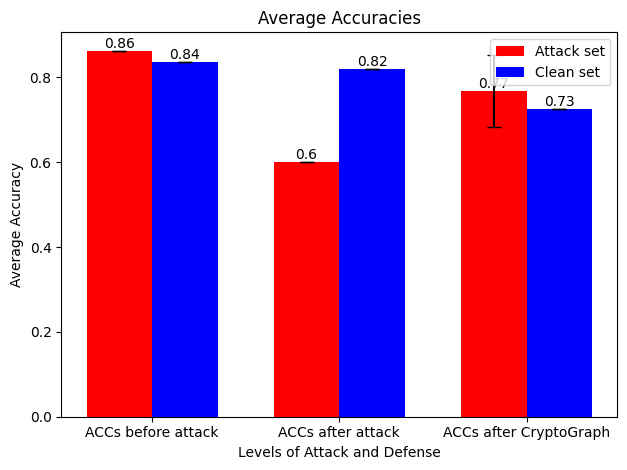

In [3]:
################################# V0 - Plotting ACcuracies #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# # Create the bar chart
# bars1 = plt.bar(x - width/2, values[::2], width, label='Attack set', color='red')
# bars2 = plt.bar(x + width/2, values[1::2], width, label='Clean set', color='blue')

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])

# Add a legend
plt.legend()

# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()

# Display the chart
plt.show()

In [ ]:
################################# Attack one node (adding label) each time to discover node conditions ###############################
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn')
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 611
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print ("val",len (idx_val))

    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)

    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)
   
    print ( f"idx_test_attack: {idx_test_attack}")
    neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    print ( f"number of target same label neighbors: {len(neighbors_same_label)}")
    print ( f"number of target opposit label neighbors: {len(neighbors_opposit_label)}")
    print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    print ( f"number of target NONE neighbors opposite label: {len(backdoor.find_non_neighbor_opposit_label(graph, selected_node))}")
    print ( f"idx_test_attack opposit label NONE neighbors: {backdoor.find_non_neighbor_opposit_label(graph, selected_node)}")

    ################################## Plotting target node before attack  #######################################
    target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # edges
    nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # labels
    nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    plt.axis('off')
    plt.show()

   
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total inserted edges : {(attacked_graph.number_of_edges() - graph.number_of_edges())}")

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results#######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()                

Loading polblogs dataset...
idx_test 950
train 40
idx_test_attack [1200 1449  965 1399  785  404 1156  292  438  874  188  237 1109  802
  821   67 1071  537 1381  658  649 1018  195  371  192  174  850  656
  250 1452   44  448  958  451 1443 1102 1380  673  517 1367 1471 1106
 1143  780  473 1023  154 1007  768  231 1242  657  559  949 1229 1233
  273  624 1147  465  149 1032 1203  268 1252  499  211  272  895  792
  976 1424   25  360 1278 1409  619  204  215  983 1477  102 1202  893
  401   22 1435 1208 1044   41  820 1098  159  770  815]
idx_test_clean [ 213 1162  758  881  981 1249  602  807  150 1129   55  238  690  962
 1324  884 1166  763   36  709 1145  206 1048 1059  910  806  377  612
  925 1175  569   17 1152   77  931  226   50  853 1210 1454  182   76
  944  930  562  525 1315  808 1392  912  421  394  760  187 1314  786
  640  453  683 1192  942 1472 1420  757   58 1431  141  267 1218  260
  864  385    4   59 1193  748  256 1281  610 1347  346  271 1215 1126
   82 1198

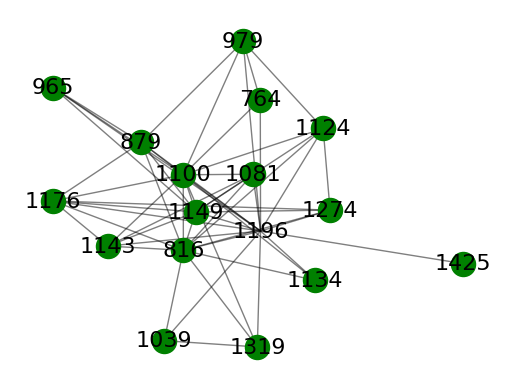

Graph with 1490 nodes and 16391 edges
total removed edges : 324
Test set results: loss= 0.5170 accuracy= 0.7158
Test set results: loss= 0.3894 accuracy= 0.8175
Test accuracy on attack set after attack:  0.7157894736842105
Test accuracy on clean set after attack:  0.8175438596491228
Dropping dissimilar edges using metric :  neighbors  on links
removed 1531 edges in polblogs 1
removed 1684 edges in polblogs 2
*** polblogs 1 ***
Test set results: loss= 0.5053 accuracy= 0.7263
*** polblogs 2 ***
Test set results: loss= 0.4755 accuracy= 0.7221
*** polblogs 1 ***
Test set results: loss= 0.4889 accuracy= 0.7474
*** polblogs 2 ***
Test set results: loss= 0.4422 accuracy= 0.7684
*** polblogs 1 ***
Test set results: loss= 0.5071 accuracy= 0.7240
*** polblogs 2 ***
Test set results: loss= 0.4792 accuracy= 0.7170
Test accuracy on attack set after Crypto'Graph:  (0.7473684210526316, 0.7684210526315789)
Test accuracy on clean set after Crypto'Graph:  (0.7239766081871345, 0.7169590643274854)


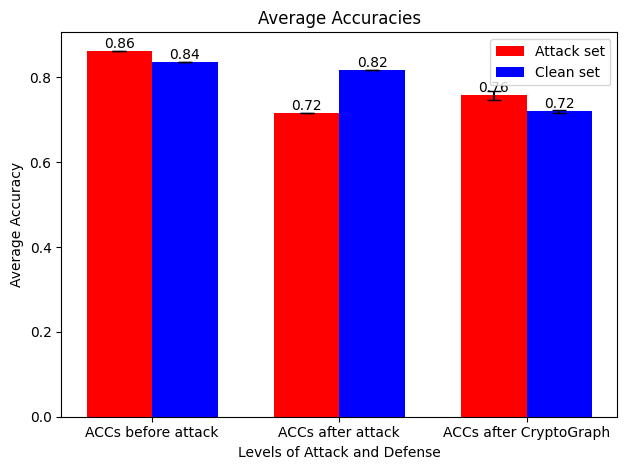

In [126]:
################################# V1: Attack by removing edges ###############################
################################# V2: Attack by removing edges + consider cummon neighbors for Crypto ###############################

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn' , seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    # selected_node = 1196
    # idx_test_attack = np.array([selected_node])
    # idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    
    #split idx_test into two parts randomly
    test_size = 0.10  # 10% for test_attack, 90% for test_clean
    idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    print ("idx_test",len (idx_test))
    print ("train",len (idx_train))
    print(f"idx_test_attack",idx_test_attack)
    print(f"idx_test_clean",idx_test_clean)
    print (idx_train)
    print ("val",len (idx_val))
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)
    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)
    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        neighbor_same = backdoor.find_same_neighbor(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, neighbor_same)
        # step1: we dont consider common neighbors
        # attacked_graph = backdoor.remove_edge1(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        
        # step2: we consider common neighbors
        nodes_for_remove = backdoor.nodes_for_remove(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.remove_edge2(attacked_graph, target_node, nodes_for_remove)
        backdoor.check_removing(attacked_graph,nodes_for_remove , target_node, budget)
   
    print ( f"idx_test_attack: {idx_test_attack}")
    neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    print ( f"number of target same label neighbors: {len(neighbors_same_label)}")
    print ( f"number of target opposit label neighbors: {len(neighbors_opposit_label)}")
    print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    print ( f"number of target NONE neighbors opposite label: {len(backdoor.find_non_neighbor_opposit_label(graph, selected_node))}")
    print ( f"idx_test_attack opposit label NONE neighbors: {backdoor.find_non_neighbor_opposit_label(graph, selected_node)}")

    
    ################################## Plotting target node before attack  #######################################
    target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # edges
    nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # labels
    nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    plt.axis('off')
    plt.show()

   
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()                

In [16]:
################# TESTTTTTTT for analysis of the graph and nodes before attack ###############################

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

#############################  preprocessing ############################
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

modified_adj =  adj.copy()

# Create a NetworkX graph from the adjacency matrix
graph = nx.from_scipy_sparse_array(modified_adj)
# Add labels to the graph
for node_id, label in enumerate(labels):
    graph.nodes[node_id]['label'] = label
# print(f"lenght of the labels : {len(labels)}") 
print(f"graph edges : {graph.number_of_edges()}")
print(f"graph nodes : {graph.number_of_nodes()}")

#########################analysis of the graph and nodes before attack ###############################

# all 
def count_neighbor_labels(graph, labels):
    count_dict = {} # dictionary type variable with key: node, and value of: (same_label, opposite_label)
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        same_label = sum(labels[neighbor] == labels[node] for neighbor in neighbors)
        opposite_label = len(neighbors) - same_label
        count_dict[node] = (same_label, opposite_label)
    return count_dict

count_dict = count_neighbor_labels(graph, labels)
# Sort nodes by the number of same-label neighbors. 
# x is tuple (node, (same_label, opposite_label)). so x[1][0] is index 0 from the second element of the tuple = same_lable 
sorted_nodes = sorted(count_dict.items(), key=lambda x: x[1][0], reverse=True) 

# print(f"Nodes and their same-label and opposite-label neighbors: {count_dict}")
print(f"sorted nodes based on the number of same-label neighbors: {sorted_nodes}")

# returns a dict of nodes which have most same label and most opposite labels with the target node
def sort_classly(count_dict, labels, target_node):
    nodes_class_same = {node: counts for node, counts in count_dict.items() if labels[node] == labels[target_node]}
    nodes_class_opp = {node: counts for node, counts in count_dict.items() if labels[node] != labels[target_node]}
    sorted_nodes_same = sorted(nodes_class_same.items(), key=lambda x: x[1][0], reverse=True)
    sorted_nodes_opp = sorted(nodes_class_opp.items(), key=lambda x: x[1][0], reverse=True)
    return sorted_nodes_same, sorted_nodes_opp

sorted_nodes_same, sorted_nodes_opp = sort_classly(count_dict, labels, 499)
# Print the top 10 nodes for each class
# print(f"The most same-label neighbors in same class of label with node {499}: {sorted_nodes_same[:10]}")
# print(f"The most same-label neighbors in class 1: {sorted_nodes_opp[:10]}")
# print (f"label of node is: {labels[671]}")

Loading polblogs dataset...
Selecting 1 largest connected components
graph edges : 16714
graph nodes : 1222
sorted nodes based on the number of same-label neighbors: [(126, (305, 46)), (671, (296, 5)), (47, (255, 22)), (837, (253, 53)), (496, (233, 41)), (767, (211, 32)), (921, (197, 14)), (1005, (197, 26)), (889, (182, 14)), (565, (174, 44)), (282, (169, 2)), (829, (167, 15)), (881, (164, 6)), (1212, (160, 19)), (1177, (155, 44)), (252, (151, 19)), (357, (145, 4)), (146, (140, 7)), (383, (138, 6)), (401, (133, 4)), (83, (131, 2)), (118, (129, 1)), (497, (129, 18)), (339, (126, 10)), (300, (125, 13)), (153, (121, 7)), (691, (121, 7)), (798, (121, 2)), (1198, (121, 17)), (693, (118, 11)), (1058, (118, 4)), (59, (116, 2)), (417, (116, 12)), (499, (114, 7)), (583, (109, 24)), (945, (109, 29)), (427, (108, 9)), (588, (108, 4)), (516, (106, 4)), (1029, (106, 14)), (1078, (105, 9)), (411, (104, 7)), (646, (103, 4)), (728, (103, 1)), (974, (103, 20)), (782, (102, 2)), (1127, (102, 3)), (375, 

Loading polblogs dataset...
idx_test 950
train 40
idx_test_attack [1200 1449  965 1399  785  404 1156  292  438  874  188  237 1109  802
  821   67 1071  537 1381  658  649 1018  195  371  192  174  850  656
  250 1452   44  448  958  451 1443 1102 1380  673  517 1367 1471 1106
 1143  780  473 1023  154 1007  768  231 1242  657  559  949 1229 1233
  273  624 1147  465  149 1032 1203  268 1252  499  211  272  895  792
  976 1424   25  360 1278 1409  619  204  215  983 1477  102 1202  893
  401   22 1435 1208 1044   41  820 1098  159  770  815]
idx_test_clean [ 213 1162  758  881  981 1249  602  807  150 1129   55  238  690  962
 1324  884 1166  763   36  709 1145  206 1048 1059  910  806  377  612
  925 1175  569   17 1152   77  931  226   50  853 1210 1454  182   76
  944  930  562  525 1315  808 1392  912  421  394  760  187 1314  786
  640  453  683 1192  942 1472 1420  757   58 1431  141  267 1218  260
  864  385    4   59 1193  748  256 1281  610 1347  346  271 1215 1126
   82 1198

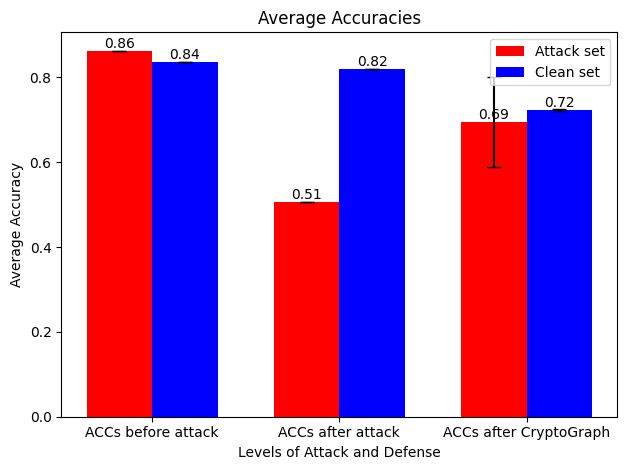

In [128]:
################### V3-0 : Attack by removing edges + adding edge: (le budget égal pour ajouter, enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset,setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    # selected_node = 1196
    # idx_test_attack = np.array([selected_node])
    # idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    test_size = 0.10  # 10% for test_attack, 90% for test_clean
    idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    print ("idx_test",len (idx_test))
    print ("train",len (idx_train))
    print(f"idx_test_attack",idx_test_attack)
    print(f"idx_test_clean",idx_test_clean)
    print ("val",len (idx_val))
    print (idx_train)
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    count_dict = backdoor.count_neighbor_labels_0(graph, labels)
    print (count_dict)        


    for target_node in idx_test_attack:
        sorted_nodes_same, sorted_nodes_opp = backdoor.sort_classly(count_dict, labels, target_node)# sort nodes based on the number of same and opposite label neighbors
        remove_budget = budget // 2
        add_budget = budget - remove_budget
        attacked_graph,removed_edges,added_edges = backdoor.add_remove(attacked_graph, target_node, sorted_nodes_same, sorted_nodes_opp, remove_budget, add_budget)
            

    print(f"Removed {len(removed_edges)} edges: {removed_edges}")
    print(f"Added {len(added_edges)} edges: {added_edges}")    
    
    print ( f"idx_test_attack: {idx_test_attack}")
    # neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    # neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    # print ( f"number of target same label neighbors before attack: {len(neighbors_same_label)}")
    # print ( f"number of target opposit label neighbors before attack: {len(neighbors_opposit_label)}")
    # print( f"idx_test_attack same all over the graph : {len(sorted_nodes_same)}")
    # print( f"idx_test_attack opposit label all over the graph: {len(sorted_nodes_opp)}")
    
    # # neighbors_same_after = backdoor.find_same_neighbor(attacked_graph, selected_node)
    # # neighbors_opposit_after = backdoor.find_opposit_neighbor(attacked_graph, selected_node)
    # print ( f"idx_test_attack same label neighbors after attack: {len(neighbors_same_after)}")
    # print ( f"idx_test_attack opposit label neighbors after attack: {len(neighbors_opposit_after)}")


    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print (f"same label all over graph : (node, (num of same label, num of opposit label)){sorted_nodes_same}")
    # print (f"as above for opposite lables{sorted_nodes_opp}")
    
    def is_neighbor(graph, node1, node2):
        return graph.has_edge(node1, node2) or graph.has_edge(node2, node1)

    # is_neighbor = is_neighbor(attacked_graph, 300, 499)
    # print ( f"label of target node is: {labels[499]}")
    # print ( f"label of node 300 is: {labels[300]}")
    # print ( is_neighbor)

    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    #print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")

    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

   
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()      
        

Loading polblogs dataset...
len of idx_test_clean 855
len of idx_test_attack 95
idx_test 950
idx_test_attack [1200 1449  965 1399  785  404 1156  292  438  874  188  237 1109  802
  821   67 1071  537 1381  658  649 1018  195  371  192  174  850  656
  250 1452   44  448  958  451 1443 1102 1380  673  517 1367 1471 1106
 1143  780  473 1023  154 1007  768  231 1242  657  559  949 1229 1233
  273  624 1147  465  149 1032 1203  268 1252  499  211  272  895  792
  976 1424   25  360 1278 1409  619  204  215  983 1477  102 1202  893
  401   22 1435 1208 1044   41  820 1098  159  770  815]
idx_test_clean [ 213 1162  758  881  981 1249  602  807  150 1129   55  238  690  962
 1324  884 1166  763   36  709 1145  206 1048 1059  910  806  377  612
  925 1175  569   17 1152   77  931  226   50  853 1210 1454  182   76
  944  930  562  525 1315  808 1392  912  421  394  760  187 1314  786
  640  453  683 1192  942 1472 1420  757   58 1431  141  267 1218  260
  864  385    4   59 1193  748  256 12

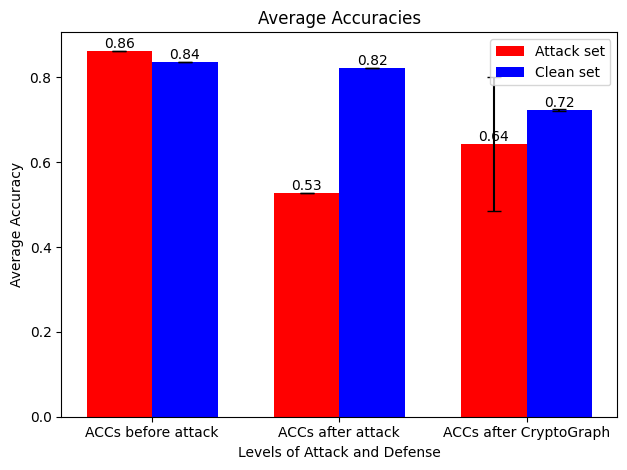

In [130]:
################### V3.1 : Attack by removing edges + adding edge: (le budget change selon l’importance pour ajouter/enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    # selected_node = 1196
    # idx_test_attack = np.array([selected_node])
    # idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    test_size = 0.10  # 10% for test_attack, 90% for test_clean
    idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
    print ("len of idx_test_clean",len (idx_test_clean))
    print ("len of idx_test_attack",len (idx_test_attack))
    print ("idx_test",len (idx_test))
    print(f"idx_test_attack",idx_test_attack)
    print(f"idx_test_clean",idx_test_clean)
    print ("train",len (idx_train))
    print ("val",len (idx_val))
    print (idx_train)
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack 
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    sorted_count_dict = backdoor.count_neighbor_labels(graph, labels)
    print ( f"idx_test_attack: {idx_test_attack}")
    for target_node in idx_test_attack:
        print(f"target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor(graph, target_node)
        neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, target_node)
        print ( f"number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print ( f"number of target opposit label neighbors before attack: {len(neighbors_opposit_label)}")
   
        attacked_graph,removed_edges,added_edges = backdoor.add_remove_v3(attacked_graph, target_node,sorted_count_dict ,budget)
        print(f"Removed {len(removed_edges)} edges: {removed_edges}")
        print(f"Added {len(added_edges)} edges: {added_edges}")    
    
      
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    #print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")


    # print( f"idx_test_attack same all over the graph : {len(sorted_nodes_same)}")
    # print( f"idx_test_attack opposit label all over the graph: {len(sorted_nodes_opp)}")
    # neighbors_same_after = backdoor.find_same_neighbor(attacked_graph, selected_node)
    # neighbors_opposit_after = backdoor.find_opposit_neighbor(attacked_graph, selected_node)
    # print ( f"idx_test_attack same label neighbors after attack: {len(neighbors_same_after)}")
    # print ( f"idx_test_attack opposit label neighbors after attack: {len(neighbors_opposit_after)}")
    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print (f"same label all over graph : (node, (num of same label, num of opposit label)){sorted_nodes_same}")
    # print (f"as above for opposite lables{sorted_nodes_opp}")
    
    # def is_neighbor(graph, node1, node2):
    #     return graph.has_edge(node1, node2) or graph.has_edge(node2, node1)

    # is_neighbor = is_neighbor(attacked_graph, 300, 499)
    # print ( f"label of target node is: {labels[499]}")
    # print ( f"label of node 300 is: {labels[300]}")
    # print ( is_neighbor)

    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

 
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35
# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()

In [ ]:
###nemoodar mese aubin baraye graph ha

import matplotlib.pyplot as plt
import numpy as np

# Example data
t_values = np.linspace(0, 0.5, 50)
accuracy_values = {
    'local_jaccard_defense': np.random.random(50),
    'local_cosine_defense': np.random.random(50),
    'local_common_neighbors_defense': np.random.random(50),
    'distributed_jaccard_defense': np.random.random(50),
    'distributed_cosine_defense': np.random.random(50),
    'distributed_common_neighbors_defense': np.random.random(50),
}

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotting on the first subplot
for key, values in accuracy_values.items():
    axs[0, 0].plot(t_values, values, label=key.replace('_', ' '))

axs[0, 0].set_title('No Attack')
axs[0, 0].set_xlabel('t (Jaccard and Cosine)')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(loc='best')
axs[0, 0].grid(True)

# Similarly, you can plot on other subplots
# This is a placeholder for illustration. You need to plot the actual data accordingly.

# Adding titles and labels for remaining subplots (repeat as necessary)
# axs[0, 1].set_title('FGSM')
# axs[1, 0].set_title('NETTACK')
# axs[1, 1].set_title('DICE')

plt.tight_layout()
plt.show()